#OSP Syllabus Classification [work in progress]

Is a document a syllabus or not? Using tagged training data, we set out to find out...

In [332]:
from osp.corpus.syllabus import Syllabus
import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

from collections import defaultdict

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RandomizedLogisticRegression

In [2]:
raw_training_df = pd.read_csv('/home/ubuntu/osp-tagging.csv')
print(raw_training_df.columns, raw_training_df.size)

Index(['﻿"id"', 'title', 'text', 'url', 'tags'], dtype='object') 84340


There are many syllabi in the training data that were not tagged. They have an empty value in the tags field that is stored as a float. Remove them, as well as tagged entries with a null in the text field.

In [43]:
training_df = raw_training_df[raw_training_df.tags.apply(
        lambda x: isinstance(x, str)) & ~raw_training_df.text.isnull()]

training_df.reset_index(inplace=True)
print("Raw row count: {}, labeled row count: {}".format(raw_training_df.shape, training_df.shape))

Raw row count: (16868, 5), labeled row count: (772, 6)


The training data is tagged from the Overview project interface. Several different tags were available:

- Course Description
- "Course Description,Not Syllabus"
- Lab Syllabus
- Lesson or Lecture
- "No Citations,Syllabus"
- Not Syllabus
- Reading List
- "Reading List,Syllabus"
- Syllabus
- "Syllabus,Lab Syllabus"
- "Syllabus,No Citations"
- "Syllabus,No Citations,Odd for some reason"
- "Syllabus,Odd for some reason"
- "Syllabus,Odd for some reason,No Citations"

This is a classifier to split syllabi from not, so as long as a document is a syllabus, regardless whether it has citations or not, or whether it is odd, it will be considered a syllabus.

In [44]:
def is_syllabus_tag(tag):
    try:
        return 'syllabus' in tag.lower() and 'not syllabus' not in tag.lower()
    except AttributeError:
        return False

is_syllabus = training_df.tags.apply(is_syllabus_tag)
positive_examples_df = training_df[is_syllabus]
negative_examples_df = training_df[~is_syllabus]

print('Positive examples: {}, negative examples: {}'.format(positive_examples_df.shape, negative_examples_df.shape))

Positive examples: (301, 6), negative examples: (471, 6)


We tokenize the syllabus text in the positive and negative examples, and featurize them for a classifier.

First pass: tf-idf features of text tokens, classified using naive bayes.

In [87]:
text_preprocessing = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer())
])
clf_nb = MultinomialNB()

In [88]:
features = text_preprocessing.fit_transform(training_df.text.values)

In [94]:
# Need dense features to index into it
features_dense = features.todense()

In [101]:
kf = KFold(n=len(training_df), n_folds=5, shuffle=True, random_state=983214)
cv_results = cross_val_score(clf_nb, features_dense, is_syllabus.values, cv=kf)
cv_results.mean()

0.86397151235860914

In [31]:
kf = KFold(n=len(training_df), n_folds=5, shuffle=True, random_state=983214)
cv_results = cross_val_score(text_clf, training_df.text.values, is_syllabus.values, cv=kf, scoring='roc_auc')
cv_results.mean()

0.94218518605467172

#### We get 86.4% mean accuracy and 94.22% mean ROC using out-of-the-box features and the multinomial NB classifier.

One question we might ask is: is this good?

The classifier returns a probability between 0 and 1 that a given document is a syllabus. In the ROC curves below, the movement of the line represents the changing false positive and true positive rates for different cutoff values. For example, if the cutoff is 0, then all documents with a probability greater than 0 of being a syllabus (i.e., all documents) will be classified as syllabi, leading us to have a perfect true positive rate but also a perfect false positive rate -- the upper right corner.

This chart shows us that we can choose a threshold somewhere on that line. For example, we can achieve a true positive rate (a recall) of 90% with only a 20% false positive rate (also known as fallout). How useful this will be in practice will depend on the ratio of syllabi to non-syllabi in the corpus, and our tolerance for errors of either kind.

In [103]:
fprs = []
tprs = []
thresholds = []

kf = KFold(n=len(training_df), n_folds=5, shuffle=True, random_state=983214)
for train, test in kf:
    clf_nb.fit(features_dense[train], is_syllabus[train])
    predictions = clf_nb.predict_proba(features_dense[test])

    fpr, tpr, threshold = roc_curve(is_syllabus[test], predictions[:, 1])
    fprs.append(fpr)
    tprs.append(tpr)
    thresholds.append(threshold)

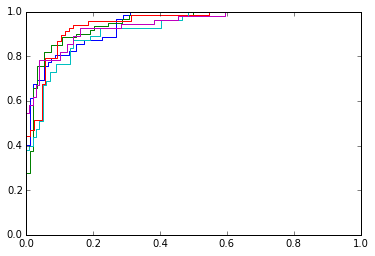

In [104]:
for i in range(len(fprs)):
    plt.plot(fprs[i], tprs[i], lw=1)

plt.show()

## Experimentation with additional classifiers and parameters

In [113]:
classifiers = {'rf': RandomForestClassifier(),
               'lr': LogisticRegression(),
               'nb': clf_nb,
               'dt': DecisionTreeClassifier()
               }

fprs = defaultdict(list)
tprs = defaultdict(list)
thresholds = defaultdict(list)

mean_fprs = {}
mean_tprs = {}
mean_aucs = {}

kf = KFold(n=len(is_syllabus), n_folds=5, shuffle=True, random_state=983214)


In [115]:
for train, test in kf:
    for clf_type, clf in classifiers.items():
        # Train and predict using selected classifier
        clf.fit(features_dense[train], is_syllabus[train])
        predictions = clf.predict_proba(features_dense[test])
        fpr, tpr, threshold = roc_curve(is_syllabus[test], predictions[:, 1])
        
        # Append results to that classifier's dictionary entry
        fprs[clf_type].append(fpr)
        tprs[clf_type].append(tpr)
        thresholds[clf_type].append(threshold)

KeyboardInterrupt: 

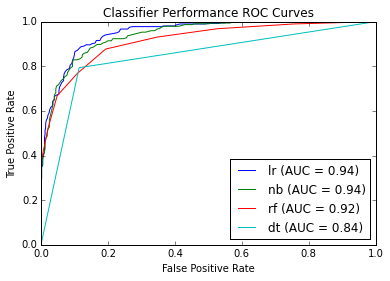

In [130]:
for clf_type in classifiers:
    mean_fprs[clf_type] = [np.mean(x) for x in zip(*fprs[clf_type])]
    mean_tprs[clf_type] = [np.mean(x) for x in zip(*tprs[clf_type])]
    mean_aucs[clf_type] = auc(mean_fprs[clf_type], mean_tprs[clf_type])
    plt.plot(mean_fprs[clf_type], mean_tprs[clf_type], lw=1, label='%s (AUC = %0.2f)' % (clf_type, mean_aucs[clf_type]))
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classifier Performance ROC Curves')
plt.legend(loc="lower right")
plt.show()

Given that logistic regression performed just as well as Naive Bayes on cross-validation without tuning the parameters, I expect it to outperform once we tune it.

### Feature Analysis

In [150]:
# We still need to grid-search for the right logit parameters.

rand_logit = RandomizedLogisticRegression(C=1, scaling=0.5, n_resampling=100)
rand_logit.fit(features, is_syllabus)

RandomizedLogisticRegression(C=1, fit_intercept=True,
               memory=Memory(cachedir=None), n_jobs=1, n_resampling=10,
               normalize=True, pre_dispatch='3*n_jobs', random_state=None,
               sample_fraction=0.75, scaling=0.5, selection_threshold=0.25,
               tol=0.001, verbose=False)

In [151]:
sorted(zip(rand_logit.all_scores_, vect.get_feature_names()), reverse=True)

[(array([ 0.9]), 'will'),
 (array([ 0.8]), 'opencourseware'),
 (array([ 0.8]), 'chapter'),
 (array([ 0.8]), 'and'),
 (array([ 0.7]), 'de'),
 (array([ 0.6]), 'la'),
 (array([ 0.6]), 'homework'),
 (array([ 0.6]), 'be'),
 (array([ 0.5]), 'week'),
 (array([ 0.5]), 'mit'),
 (array([ 0.5]), 'exam'),
 (array([ 0.5]), 'due'),
 (array([ 0.4]), 'student'),
 (array([ 0.4]), 'class'),
 (array([ 0.3]), 'you'),
 (array([ 0.3]), 'that'),
 (array([ 0.3]), 'or'),
 (array([ 0.3]), 'grade'),
 (array([ 0.3]), 'ch'),
 (array([ 0.3]), '10'),
 (array([ 0.2]), 'points'),
 (array([ 0.2]), 'lab'),
 (array([ 0.2]), 'for'),
 (array([ 0.1]), 'was'),
 (array([ 0.1]), 'the'),
 (array([ 0.1]), 'of'),
 (array([ 0.1]), 'isbn'),
 (array([ 0.1]), 'hours'),
 (array([ 0.1]), 'edu'),
 (array([ 0.1]), 'der'),
 (array([ 0.1]), 'assignment'),
 (array([ 0.1]), '11'),
 (array([ 0.]), 'ﾚﾌｧﾚﾝｽﾌﾞｯｸｺｰﾅｰにあり'),
 (array([ 0.]), 'ｋ421'),
 (array([ 0.]), 'ｋ211'),
 (array([ 0.]), 'ｋ115'),
 (array([ 0.]), 'ｋ113'),
 (array([ 0.]), 'ﬂexible'

### Baseline comparisons
My intuitive suspicion is that a set of hand-crafted rules could perform remarkably well at classifying syllabi. I'm curious to see how it compares to the automated methods above. The rules would be along the lines of:

Has one of the following words:
- syllabus
- class
- assignment
- due
- spring
- fall

In [194]:
syllabus_words = ['syllabus', 'class', 'assignment', 'due', 'spring', 'fall']
# TODO

AttributeError: 'list' object has no attribute 'ndim'

### Parameter Tuning (TODO)

In [24]:
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2')
}

grid_search = GridSearchCV(text_clf, parameters, n_jobs=-1, verbose=1)
grid_search.fit(training_df.text.values, is_syllabus.values)
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done   1 jobs       | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  12 out of  18 | elapsed:  1.3min remaining:   38.8s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.8min finished


Best score: 0.845
Best parameters set:
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)


In this grid search across parameters, having a cutoff that eliminates words with document frequency above 0.5 is more effective than cutoffs at 0.75 and 1. Bigrams also perform better than unigrams. The best score here is lower than the mean score in our stratified run above, so more tests are warranted.

## Classify documents

First step is to take all of the training data, and feed that through the classifier.

In [238]:
text_preprocessing.fit(training_df.text.values)

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, charset=None,
        charset_error=None, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preproc...y=None)), ('tfidf', TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True))])

In [239]:
f = text_preprocessing.transform(training_df.text)

In [248]:
from scipy.sparse import csr_matrix
csr_matrix(features_dense)

<772x370601 sparse matrix of type '<class 'numpy.bool_'>'
	with 951353 stored elements in Compressed Sparse Row format>

In [249]:
lr.fit(f, is_syllabus)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

Now, run documents through the classifier

In [289]:
from playhouse.postgres_ext import ServerSide
from osp.corpus.models.text import Document_Text
 
# Select all texts.
query = Document_Text.select()



# Mapping from a syllabus id to its predicted probability of being a syllabus
predictions = {}

# Counter
i = 0

# Wrap the query in a server-side cursor, to avoid
# loading the plaintext for all docs into memory.
for sy in ServerSide(query):
    examples.append(sy.text)
   
    # Featurize text of document
    sy_features = text_preprocessing.transform([sy.text])

    # Predict probability
    p  = lr.predict_proba(sy_features)[0,1]

    predictions[sy.document] = p
    if i % 100 == 0:
        print('{}. {}: {}'.format(i, sy.document, p))
    i += 1

0. 000/e19a5edc6f3d31fb2766f178efd62: 0.18718611515007838
100. db6/6f78733e1e5158f83ca3f93a36e36: 0.25113209680491283
200. 924/312e5b6eb41ea0d70bf414323c340: 0.4631602300118904
300. 6db/d64764f19f172d951d17c4abd772e: 0.17808580947711275
400. 492/85dcc6845fefb861cb8b693104d73: 0.5273794775571683
500. 000/28f95449ebc20284972ea65610f18: 0.21419721106499426
600. 492/a89004354d2565043b7ed2cce01af: 0.7105054556775542
700. db6/76c8eb3da9907b6b395cdd531c23c: 0.7427239814653236
800. db6/62456be97b851127197308bdcede6: 0.14607633065629225
900. 924/9a7b1a157e33bc191b6fe01bfb33b: 0.7363078480304811
1000. b6d/3506b45e8743b90dfee202f42ca0e: 0.7103463050592445
1100. 6db/f47ebb7c9d5aa0c889b207592ff3a: 0.4927423797280297
1200. db6/3c7476092a222f4fb7484f47f292d: 0.4763639190490289
1300. 6db/6c48884f1b9e88c653c1c921449d6: 0.7679880182402934
1400. 924/c2c22fb3cc20b66d46ee56b7df84f: 0.3802862588196427
1500. 492/f8cbc420c5319df723da5ccd10af7: 0.28283452896409544
1600. 924/afc2a7780a7b0ea232a22a49be3c5: 0.218

KeyboardInterrupt: 

How well did we do? I stop at this point to label some documents, to make sure our training sample was representative.

In [304]:
labels = {}
for d in predictions:
    t = [x.text for x in Document_Text.select().where(Document_Text.document == d)]
    print(t)
    label = input('y/n/q')
    
    if label == 'y':
        labels[d] = True
    elif label == 'n':
        labels[d] = False
    elif label == 'q':
        break
    else:
        print('Skipping...')
        continue

[" Module: Strategic International HRM Archived Version 2006 - 2007 Sep OCT Nov 20 2006 2007 2008 1 captures\n20 Oct 07 - 20 Oct 07 Close\nHelp DCU RECEIVES OVER 23m in PRTLI RESEARCH FUNDING -100% 'SUCCESS' RATE - STUDY AT DCU - RESEARCH - MORE ABOUT DCU - NEWS search Registry Module Specifications Archived Version 2006 - 2007 Module Title Strategic International HRM Module Code HR524 School DCUBS Online Module Resources Module Co-ordinatorProf Kathy MonksOffice NumberQ242 Level 5 Credit Rating 5 Pre-requisite None Co-requisite None Module Aims To enable managers to gain a comprehensive understanding of the critical issues in strategic HRM. Learning Outcomes The manager will gain both a theoretical and practical understanding of key issues in strategic HRM and an insight into the latest research findings on strategic HRM issues. The manager's communication, presentation and team working abilities will be enhanced through the assessment for this module. Indicative Time Allowances Hours

In [314]:
tp = 0
fp = 0
tn = 0
fn = 0

for l in labels:
    if predictions[l] > 0.5:
        if labels[l] == True:
            tp += 1
        else:
            fp += 1
    
    if predictions[l] < 0.5:
        if labels[l] == False:
            tn += 1
        else:
            fn += 1

In [320]:
tp, fp, tn, fn

(45, 3, 34, 16)

I labeled 98 documents, 48 of which were syllabi. That gave us an overall accuracy of (45 + 34) / 98 = 80.1% -- slightly lower than what we achieved in cross-validation. The majority of error comes in with false negatives, which means a threshold of 0.5 might be too tight.

In [329]:
fpr, tpr, t = roc_curve([labels[x] for x in labels], [predictions[x] for x in labels])

([<matplotlib.lines.Line2D at 0x7f54c05504e0>], 0.88303057155516163)

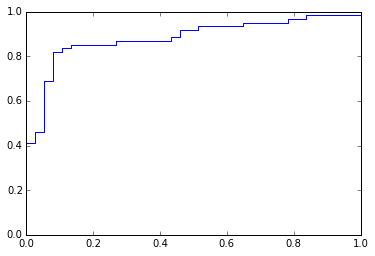

In [331]:
plt.plot(fpr, tpr), auc(fpr, tpr)

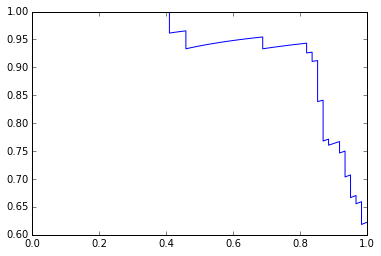

In [334]:
p, r, t = precision_recall_curve([labels[x] for x in labels], [predictions[x] for x in labels])
plt.plot(r, p)

In this graph, you can see that there is a sharp dropoff of precision around the 80% recall. To me, this implies that while many documents are obviously syllabi or not, at a certain point, there is a sharp increase in ambiguity. This mirrors my experience with labeling the syllabi, where sometimes it was close enough that I gave ambiguous responses across trials. For example, I didn't have a rigorous take toward how to classify course teasers in catalogs.

In [319]:
import json
with open('extra_labels.json', 'w') as out:
    json.dump(labels, out)

In [347]:
additional_training = []
for l in labels:
    t = [x.text for x in Document_Text.select().where(Document_Text.document == l)][0]
    additional_training.append({
            'id': l,
            'text': t,
            'is_syllabus': labels[l]
            })

In [349]:
additional_training_df = pd.DataFrame(additional_training)

In [370]:
training_texts = np.concatenate((training_df.text.values, additional_training_df.text.values))
training_labels = np.concatenate((is_syllabus.values, additional_training_df.is_syllabus.values))

In [371]:
full_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                     ('clf_lr', LogisticRegression())
])

parameters = {
    'vect__max_df': (0.5, 1),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams,
    'clf_lr__C': (1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10),
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2')
}

grid_search = GridSearchCV(full_clf, parameters, n_jobs=1, verbose=1, scoring='roc_auc')
grid_search.fit(training_texts, training_labels)
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    6.4s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed: 12.2min


Fitting 3 folds for each of 28 candidates, totalling 84 fits
Best score: 0.953
Best parameters set:
	clf_lr__C: 10
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)


[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed: 21.3min finished


In [373]:
full_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                     ('clf_lr', LogisticRegression())
])

parameters = {
    'vect__max_df': (0.5,),
    'vect__ngram_range': ((1, 2),),  # unigrams or bigrams,
    'clf_lr__C': (10, 100, 1000),
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2')
}

grid_search = GridSearchCV(full_clf, parameters, n_jobs=1, verbose=1, scoring='roc_auc')
grid_search.fit(training_texts, training_labels)
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   28.2s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  4.0min finished


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best score: 0.954
Best parameters set:
	clf_lr__C: 100
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)


In [407]:
full_clf = Pipeline([('vect', CountVectorizer(max_df=0.5, ngram_range=(1, 2))),
                      ('tfidf', TfidfTransformer()),
                     ('clf_lr', LogisticRegression())
])

In [398]:
# extract additional features from the syllabus
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction import DictVectorizer

class BasicInfoExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self
    
    def transform(self, docs):
        return [{ 'length': len(x) } for x in docs]

In [401]:
full_clf_with_length = Pipeline([
        ('features', FeatureUnion(
                transformer_list=[
                    
                    # Calculate the length of the document
                    ('summary_stats', Pipeline([
                            ('stats', BasicInfoExtractor()),
                            ('dv', DictVectorizer())])),
                    
                    # Grab the bag of words and do tf-idf
                    ('vocab', Pipeline([
                            ('vect', CountVectorizer(max_df=0.5, ngram_range=(1, 2))),
                            ('tfidf', TfidfTransformer())]))],

            )
        ),
        ('clf_lr', LogisticRegression(C=100))])

In [403]:
kf = KFold(n=len(training_texts), n_folds=3, shuffle=True, random_state=983214)
cv_results = cross_val_score(full_clf_with_length, training_texts, training_labels, cv=kf, scoring='roc_auc')
cv_results.mean()

0.51572965550717798

Whoah. This is atrocious. Let's run it without the length.

In [409]:
full_clf.fit(training_texts, training_labels)

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, charset=None,
        charset_error=None, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=1,
        ngram_range=(1, 2), preproc...e, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001))])

In [ ]:
from playhouse.postgres_ext import ServerSide
from osp.corpus.models.text import Document_Text
import time

# Select all texts.
query = Document_Text.select()

# Mapping from a syllabus id to its predicted probability of being a syllabus
predictions2 = {}

# Counter
i = 0

# Wrap the query in a server-side cursor, to avoid
# loading the plaintext for all docs into memory.
for sy in ServerSide(query):
   
    # Predict probability
    p  = full_clf.predict_proba([sy.text])[0,1]

    predictions[sy.document] = p
    if i < 5 or i % 10000 == 0:
        print('{}. {}: {}'.format(i, sy.document, p))
    i += 1

0. dc7/63864fd102cda422a3336a253f4b5: 0.2641848963786986
1. 4a1/3672b50b3bc9e17203be269132326: 0.17882957059440863
2. 4a1/7337f7d0a8501b066a84132b5fc7c: 0.7334698700743912
3. 932/c9fadb9e3aa522910900dcbf2e308: 0.18920748053192663
4. 259/05bd26a0662e9b3390f5c6d9881e9: 0.5780535111763904